## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 머신러닝응용
- 평가일 : 03.28
- 성명 : 마경수
- 점수 :

문제 : LMEMBERS의 상품구매데이터를 이용하여 개인맞춤 상품 추천솔루션을 구축 후 다양한 활용 방안을 시현하세요. 

사용자 : 19383명, 아이템 : 3520개 소분류명

# 1. 아이템 기반 최근접 이웃 협업 필터링
---

## 1.1. 구매빈도 기준
---

### 1.1.1. 데이터 전처리
---

In [2]:
import cx_Oracle
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')

In [ ]:
con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql = 'SELECT 고객번호, 소분류명, COUNT(소분류명) 구매빈도 FROM LCL2 GROUP BY 고객번호, 소분류명'
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호', '소분류명', '구매빈도']
u_i_df = pd.DataFrame(x, columns = columns)
cursor.close()
con.commit()
con.close()

In [ ]:
# 사용자 - 아이템 테이블 만듦
u_i_df.columns = ['고객번호', '소분류명', '구매빈도']
u_i_df

,고객번호,소분류명,구매빈도
0,00001,특산물행사,2
1,00001,한우앞다리,1
2,00001,치즈,1
3,00003,콜라,15
4,00003,깻잎,1
...,...,...,...
6135638,00886,미나리,1
6135639,00884,식빵류,1
6135640,19211,수예소품,1
6135641,00969,창작용품,1


In [ ]:
# 사용자 - 아이템 피봇테이블
# 구매반도를 평점으로 사용한다, Nan 값은 0으로 채워줌 
u_i_matrix = u_i_df.pivot(values = '구매빈도', index = '고객번호', columns = '소분류명').fillna(0)
u_i_matrix

소분류명,14K,2단우산,3단우산,3분요리류,4대 B/D,5 ON THE GO,ACC Bloom (1F),ACC Bloom (3F),AK골프,ANDZ,...,휴대폰기타용품,휴모니아,휴지류,휴지통,흑미,흑미류,흰다리새우,히터,히터기,힐앤토트
고객번호,,,,,,,,,,,,,,,,,,,,,
00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19379,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.1.2. 아이템 간 유사도 산출
---

In [ ]:
# 코사인 유사도를 사용하기 위해 행렬 전치
u_i_matrix_T = u_i_matrix.T

# 코사인 유사도를 이용하여 아이템간 유사도 산출
item_sim = cosine_similarity(u_i_matrix_T, u_i_matrix_T)
item_sim_df = pd.DataFrame(item_sim, index = u_i_matrix.columns, columns = u_i_matrix.columns)

### 1.1.3. 개인화된 아이템 추천
---

In [ ]:
# 개인화 예측 평점 사용자 함수 : 해당 아이템과 다른 모든 아이템 간의 유사도 벡터 적용

def predict_freq(freq_arr, item_sim_arr):
    freq_pred = np.dot(freq_arr, item_sim_arr) / np.array((np.abs(item_sim_arr).sum(axis = 1)))
    return freq_pred

freq_pred = predict_freq(u_i_matrix.values, item_sim_df.values)
freq_pred_matrix = pd.DataFrame(freq_pred, index = u_i_matrix.index, columns = u_i_matrix.columns)
freq_pred_matrix

소분류명,14K,2단우산,3단우산,3분요리류,4대 B/D,5 ON THE GO,ACC Bloom (1F),ACC Bloom (3F),AK골프,ANDZ,...,휴대폰기타용품,휴모니아,휴지류,휴지통,흑미,흑미류,흰다리새우,히터,히터기,힐앤토트
고객번호,,,,,,,,,,,,,,,,,,,,,
00001,1.683060,0.418229,0.386661,0.275013,1.201124,1.250495,0.625299,1.529785,1.130204,1.114044,...,0.239050,1.734643,2.166681,0.409543,0.388504,0.273384,0.276238,0.323832,0.147265,1.816816
00002,1.926043,0.313787,0.236228,0.205510,1.353291,1.438579,0.742163,1.826596,1.139538,1.178089,...,0.121440,1.819076,3.009575,0.398015,0.198466,0.205270,0.215191,0.169778,0.051245,1.797230
00003,0.275188,1.284467,1.476241,0.281064,0.385493,0.215797,0.190369,0.264196,0.282332,0.273008,...,0.806626,0.011894,0.193930,0.305697,1.624086,0.271970,0.282050,1.867469,0.148023,0.310659
00004,1.201328,0.389850,0.401309,0.277635,0.873132,0.880396,0.469818,1.124765,0.747078,0.768123,...,0.266607,0.999428,1.706516,0.367526,0.392393,0.276184,0.283108,0.316167,0.220975,1.102380
00005,1.283192,0.180016,0.119060,0.126546,0.864102,0.946497,0.470110,1.239431,0.617919,0.739648,...,0.082088,1.022773,2.392286,0.251138,0.102263,0.124606,0.132909,0.070201,0.024670,1.162047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19379,0.242064,0.498121,0.534233,0.192788,0.266432,0.179813,0.192954,0.249019,0.213493,0.215461,...,0.245989,0.047275,0.214159,0.176356,0.504013,0.160563,0.152778,0.584959,0.152394,0.220595
19380,0.126729,0.457743,0.461115,0.172699,0.178976,0.107932,0.095297,0.141542,0.160256,0.148883,...,0.207002,0.012500,0.106747,0.145040,0.430298,0.134271,0.130576,0.512944,0.064009,0.117400
19381,0.305909,0.403835,0.410744,0.691189,0.387747,0.366827,0.141744,0.276272,0.333669,0.355482,...,0.592331,0.060368,0.325644,0.560771,0.384577,0.705180,0.706958,0.308197,0.692829,0.226601


In [ ]:
# 사용자가 평점을 부여한 아이템에 대해서만 예측 성능 평가

def get_mse(pred, actual):
    
    pred = pred[actual.nonzero()]
    actual = actual[actual.nonzero()]
    return mean_squared_error(pred, actual)

print('mse :', get_mse(freq_pred, u_i_matrix.values))

mse : 109.66673684395926


In [ ]:
# Top_N 유사도를 가지는 아이템을 선택하여 개인화 예측 평점을 만드는 사용자 함수

def predict_freq_topsim(freq_arr, item_sim_arr, n = 20):
    pred = np.zeros(freq_arr.shape)
    
    for col in range(freq_arr.shape[1]):
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        for row in range(freq_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(freq_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
            
    return pred

freq_pred_20 = predict_freq_topsim(u_i_matrix.values, item_sim_df.values, n = 20)
print('mse :', get_mse(freq_pred_20, u_i_matrix.values))

mse : 82.60212659409054


In [ ]:
user_rating_id = u_i_matrix.loc['01231',:]
user_rating_id[user_rating_id > 0].sort_values(ascending = False)[:10]

소분류명
종량제봉투     82.0
국산담배      77.0
일반소주      61.0
공병/공박스    58.0
가공우유      55.0
사이다       42.0
어린이음료     40.0
생수        37.0
일반우유      32.0
즉석도정미     30.0
Name: 01231, dtype: float64

In [ ]:
# 아이템을 개인 사용자에게 추천하는 사용자 함수
# 구매빈도만을 고려하니 식품에서만 추천이 일어나는 것을 알 수 있었음
def recomm_item_by_userid(pred_df, userId, top_n = None):
    recomm_item = pred_df.loc[userId].sort_values(ascending = False)[:top_n]
    return recomm_item

recomm_items = recomm_item_by_userid(freq_pred_matrix, '01231', top_n = 10)

recomm_items = pd.DataFrame(data = recomm_items.values, index = recomm_items.index, columns = ['pred_score'])

recomm_items

,pred_score
소분류명,
일반소주,4.159546
공병/공박스,4.049904
국산담배,3.888738
서류정리용품,3.622437
칵테일소주,3.245637
가공우유,3.201365
일반요구르트,3.193335
유아/아동용치약,3.192174
바아이스크림,3.174925


## 1.2. 구매지수(구매빈도 + 구매액수) 기준
---
- 구매 액수를 고려하게 된 이유 : value로 단순 구매빈도만 고려할 경우, 식품에서만 추천이 될 확률이 높았기 때문에 구매금액을 함께 고려하기로 했다. 
$$$$
- 상품의 특성을 고려한 가중치 선정 방법 :   
$$$$
 - 모든 고객의 편의품 빈도 / 모든 고객의 구매 전체 빈도 = 0.9097
 - 모든 고객의 선매품 빈도 / 모든 고객의 구매 전체 빈도 = 0.0877
 - 모든 고객의 전문품 빈도 / 모든 고객의 구매 전체 빈도 = 0.0024 
 $$$$
 - 모든 고객의 편의품 액수 / 모든 고객의 구매 전체 액수 = 0.3748
 - 모든 고객의 선매품 액수 / 모든 고객의 구매 전체 액수 = 0.5291
 - 모든 고객의 전문품 액수 / 모든 고객의 구매 전체 액수 = 0.0961
$$$$
  - 빈도 가중치 = 빈도 / 빈도 + 액수 
  - 액수 가중치 = 액수 / 빈도 + 액수 
$$$$
  - ex_편의품의 빈도 가중치)  0.9097 / 0.9097 +  0.3748 = 0.7
  - ex_편의품의 액수 가중치)  0.3748 / 0.9097 +  0.3748 = 0.3


### 1.2.1. 제휴사-세분류
---
- 제휴사 : A, B, C, D
- 세분류 : 편의품, 선매품, 전문품 (고객의 상품별 구매 행동 특성을 고려한 분류)
- 상품별 구매액수와 구매빈도의 패턴이 완전히 다르기 때문에 골고루 추천을 해주기 위해서 제휴사와 세분류 별로 12가지로 나눠서 보게 되었다. 

#### 1.2.1.1. 데이터 전처리
---
- 제휴사, 세분류 별로 나누기

In [3]:
con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql = '''SELECT 고객번호, 제휴사, 세분류명, 분류, 소분류명, count(구매금액) 구매빈도, sum(구매금액) 구매금액 from lcl2
group by 고객번호, 제휴사, 세분류명, 분류, 소분류명
order by 고객번호'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호', '제휴사', '세분류명', '카테고리', '소분류명', '구매빈도', '구매금액']
df = pd.DataFrame(x, columns = columns)
cursor.close()
con.commit()
con.close()
df.head()

,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액
0,00001,A,선매품,가구/인테리어,L.B,3,599450
1,00001,A,선매품,가구/인테리어,N.B,3,1445750
2,00001,A,선매품,가구/인테리어,수예단기행사,1,240000
3,00001,A,선매품,가구/인테리어,수예소품,3,91390
4,00001,A,선매품,가구/인테리어,카페트,3,217550


In [5]:
# 고객 별 카테고리 구매 비중 구하기

ratio = pd.read_csv('ratio.csv', encoding = 'cp949', index_col = 0)
ratio['고객번호'] = ratio['고객번호'].astype(str).str.zfill(5)
ratio['추천개수']=ratio['추천개수'].replace(0,1)
ratio.head()

,소분류명,구매빈도,고객번호,비중,추천개수
0,가공식품,232,00001,0.219489,7.0
1,가구/인테리어,18,00001,0.017029,1.0
2,디지털/가전,13,00001,0.012299,0.0
3,명품,1,00001,0.000946,0.0
4,신선식품,259,00001,0.245033,7.0


In [179]:
# 제휴사별로 나눠서 데이터프레임으롬 만들기
def get_ui_df(df):
    df1 = df.copy()
    
    df1_a = df1.loc[df1['제휴사'] == 'A']
    df1_b = df1.loc[df1['제휴사'] == 'B']
    df1_c = df1.loc[df1['제휴사'] == 'C']
    df1_d = df1.loc[df1['제휴사'] == 'D']
    
    return df1_a, df1_b, df1_c, df1_d


# 제휴사별로 나뉜 데이터프레임을 다시 세분류로 나눠 지수화하기
def get_indexing(df):
    df1 = df.copy()
    try:
        df_shop_pivot = pd.DataFrame()
        df_shop = df1.loc[df['세분류명'] == '선매품']
        df_shop['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_shop[['구매빈도']]) * 0.8) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_shop[['구매금액']]) * 0.2)
        df_shop_pivot = df_shop.pivot(index = ['고객번호', '제휴사', '세분류명'], columns = '소분류명', values = '구매지수').fillna(0)

        df_conv_pivot = pd.DataFrame()
        df_conv = df1.loc[df['세분류명'] == '편의품']
        df_conv['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_conv[['구매빈도']]) * 0.8) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_conv[['구매금액']]) * 0.2)
        df_conv_pivot = df_conv.pivot(index = ['고객번호', '제휴사', '세분류명'], columns = '소분류명', values = '구매지수').fillna(0)

        df_spec_pivot = pd.DataFrame()
        df_spec = df1.loc[df['세분류명'] == '전문품']
        df_spec['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_spec[['구매빈도']]) * 0.8) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_spec[['구매금액']]) * 0.2)
        df_spec_pivot = df_spec.pivot(index = ['고객번호', '제휴사', '세분류명'], columns = '소분류명', values = '구매지수').fillna(0)
    except:
        pass
    
    return df_shop_pivot, df_conv_pivot, df_spec_pivot

##### 1.2.1.1.1. A제휴사
---

In [ ]:
df_a_shop, df_a_conv, df_a_spec = get_indexing(df_a)

display(df_a_shop.head())
display(df_a_conv.head())
display(df_a_spec.head())

##### 1.2.1.1.2. B제휴사
---

In [ ]:
df_b_shop, df_b_conv, df_b_spec = get_indexing(df_b)

display(df_b_shop.head())
display(df_b_conv.head())
display(df_b_spec.head())

##### 1.2.1.1.3. C제휴사
---

In [ ]:
df_c_shop, df_c_conv, df_c_spec = get_indexing(df_c)

display(df_c_shop.head())
display(df_c_conv.head())
display(df_c_spec.head())

##### 1.2.1.1.4. D제휴사
---

In [ ]:
df_d_shop, df_d_conv, df_d_spec = get_indexing(df_d)

display(df_d_shop.head())
display(df_d_conv.head())
display(df_d_spec.head())

### 1.2.2. 카테고리 별
---
- 어떤 제휴사에는 전문품이 없는 경우가 존재하여 제휴사를 통합하여 분류한 카테고리별로 추천을 진행하게 되었다. 
- 고객의 카테고리별 구매 비중을 고려해서 종합적인 추천을 진행할 수 있었다.
 - 비중 = 카테고리별 구매 빈도 / 모든 카테고리 구매빈도 합
  * 추천 개수는 비중을 총 추천해줄 개수인 30으로 곱한 뒤 반올림한 값임

In [6]:
random = pd.read_csv('ratio.csv', encoding = 'cp949', index_col = 0)
random[random['고객번호'] ==  1]

,소분류명,구매빈도,고객번호,비중,추천개수
0,가공식품,232,1,0.219489,7.0
1,가구/인테리어,18,1,0.017029,1.0
2,디지털/가전,13,1,0.012299,0.0
3,명품,1,1,0.000946,0.0
4,신선식품,259,1,0.245033,7.0
5,외식,164,1,0.155156,5.0
6,유아동,3,1,0.002838,0.0
7,의류,189,1,0.178808,5.0
8,의약품/의료기기,3,1,0.002838,0.0
9,일상용품,121,1,0.114475,3.0


#### 1.2.2.1. 데이터 전처리
---

In [180]:
# 카테고리별로 나눠서 데이터프레임으롬 만들기
def get_ui_df(df):
    df1 = df.copy()
    
    df_cats = []
    for i in list(df1['카테고리'].unique()):
        df_cat = df.loc[df['카테고리'] == i].sort_values(by = '제휴사')
        df_cats.append(df_cat)
    
    return df_cats

# 카테고리별로 나뉜 데이터프레임을 다시 세분류로 나눠 지수화하기
def get_indexing(df):
    df1 = df.copy()
    
    if df1['세분류명'].unique() == '선매품':
        df1 = df1.loc[df['세분류명'] == '선매품']
        df1['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df1[['구매빈도']]) * 0.14) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df1[['구매금액']]) * 0.86)
        df1_pivot = df1.drop('세분류명', axis = 1).pivot(index = ['고객번호'], columns = ['제휴사', '카테고리', '소분류명'], values = '구매지수').fillna(0)

    elif df1['세분류명'].unique() == '편의품':
        df1 = df1.loc[df['세분류명'] == '편의품']
        df1['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df1[['구매빈도']]) * 0.7) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df1[['구매금액']]) * 0.3)
        df1_pivot = df1.drop('세분류명', axis = 1).pivot(index = ['고객번호'], columns = ['제휴사', '카테고리', '소분류명'], values = '구매지수').fillna(0)

    elif df1['세분류명'].unique() == '전문품':
        df1 = df1.loc[df['세분류명'] == '전문품']
        df1['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df1[['구매빈도']]) * 0.025) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df1[['구매금액']]) * 0.975)
        df1_pivot = df1.drop('세분류명', axis = 1).pivot(index = ['고객번호'], columns = ['제휴사', '카테고리', '소분류명'], values = '구매지수').fillna(0)
    
    return df1_pivot

In [181]:
df_cats = get_ui_df(df)

for i in range(len(df_cats)):
    display(get_indexing(df_cats[i]).head())

제휴사           A                                                         \
카테고리    가구/인테리어                                                          
소분류명        L.B      수예소품   소파       N.B      한실침구      아동침구 건강베개 종합가구   
고객번호                                                                     
00001  1.462045  1.139918  0.0  1.998627  3.109675  0.000000  0.0  0.0   
00002  1.115150  1.595029  0.0  1.198519  0.000000  1.096395  0.0  0.0   
00004  1.233714  0.000000  0.0  1.141779  0.000000  0.000000  0.0  0.0   
00005  0.000000  1.175573  0.0  0.000000  0.000000  0.000000  0.0  0.0   
00006  1.157630  0.000000  0.0  1.626608  0.000000  1.062731  0.0  0.0   

제휴사                   ...       B            C                           \
카테고리                  ... 가구/인테리어      가구/인테리어                            
소분류명        카페트 일반침대  ...   로만쉐이드  수납함      침대 수도용품 성인이불/이불커버 원예공구/살수용품   
고객번호                  ...                                                 
00001  1.219908  0.0  ...     0.0  0.0     0.0  0.0       0.0       0.0   
00002  0.000000  0.0  ...     0.0  0.0     0.0  0.0       0.0       0.0   
00004  0.000000  0.0  ...     0.0  0.0     0.0  0.0       0.0       0.0   
00005  0.000000  0.0  ...     0.0  0.0     0.0  0.0       0.0       0.0   
00006  0.000000  0.0  ...     0.0  0.0     0.0  0.0       0.0       0.0   

제휴사                              
카테고리                             
소분류명  테이블스탠드 선반장/행거 조명등기구 LED램프  
고객번호                             
00001    0.0    0.0   0.0   0.0  
00002    0.0    0.0   0.0   0.0  
00004    0.0    0.0   0.0   0.0  
00005    0.0    0.0   0.0   0.0  
00006    0.0    0.0   0.0   0.0  

[5 rows x 125 columns]

제휴사           A                                                              \
카테고리     디지털/가전                                                               
소분류명      MP3 外     수입냉장고      전기밥솥    수입소형가전       에어컨 국산냉장고.세탁기 IT 게임기S/W   
고객번호                                                                          
00001  1.114363  0.000000  1.748760  1.378441  1.616426  2.161476       0.0   
00002  0.000000  0.000000  2.076006  1.475417  1.176823  0.000000       0.0   
00003  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000       0.0   
00005  0.000000  1.014436  0.000000  0.000000  0.000000  0.000000       0.0   
00007  0.000000  0.000000  0.000000  1.010935  0.000000  0.000000       0.0   

제휴사                           ...        C                                     \
카테고리                          ...   디지털/가전                                      
소분류명      에스프레소  컴퓨터 수입청소기 외  ... 케이스/보호필름 핸디형청소기  다리미 소형디지털가전액세서리  제습기 라디에이터   
고객번호                          ...                                               
00001  0.000000  0.0     0.0  ...      0.0    0.0  0.0         0.0  0.0   0.0   
00002  0.000000  0.0     0.0  ...      0.0    0.0  0.0         0.0  0.0   0.0   
00003  0.000000  0.0     0.0  ...      0.0    0.0  0.0         0.0  0.0   0.0   
00005  0.000000  0.0     0.0  ...      0.0    0.0  0.0         0.0  0.0   0.0   
00007  1.104785  0.0     0.0  ...      0.0    0.0  0.0         0.0  0.0   0.0   

제휴사                 D               
카테고리           디지털/가전               
소분류명  녹즙기/원액기 이어폰/헤드폰 헤어드라이어 헤어세팅기  
고객번호                                
00001     0.0     0.0    0.0   0.0  
00002     0.0     0.0    0.0   0.0  
00003     0.0     0.0    0.0   0.0  
00005     0.0     0.0    0.0   0.0  
00007     0.0     0.0    0.0   0.0  

[5 rows x 163 columns]

제휴사           A                                                             \
카테고리        유아동                                                              
소분류명     수입 아동복 유아용품  토들러   L/C 아동복   N/B 아동복       내의 단기행사(아동복)       유아복   
고객번호                                                                         
00001  1.004652  0.0  0.0  0.000000  0.000000  0.00000       0.0  1.003305   
00002  0.000000  0.0  0.0  1.043791  1.055414  1.07562       0.0  1.211632   
00004  0.000000  0.0  0.0  0.000000  0.000000  0.00000       0.0  0.000000   
00005  1.034403  0.0  0.0  0.000000  0.000000  0.00000       0.0  0.000000   
00006  0.000000  0.0  0.0  0.000000  0.000000  0.00000       0.0  0.000000   

제휴사                ...      C                                     D         \
카테고리               ...    유아동                                   유아동          
소분류명  아동놀이시설 아동신발  ... 젖병/젖꼭지 아동서적 유아목욕용품 유아음료 역할놀이 여아드레스및소품 유아목욕용품 유아용화장품   
고객번호               ...                                                       
00001    0.0  0.0  ...    0.0  0.0    0.0  0.0  0.0      0.0    0.0    0.0   
00002    0.0  0.0  ...    0.0  0.0    0.0  0.0  0.0      0.0    0.0    0.0   
00004    0.0  0.0  ...    0.0  0.0    0.0  0.0  0.0      0.0    0.0    0.0   
00005    0.0  0.0  ...    0.0  0.0    0.0  0.0  0.0      0.0    0.0    0.0   
00006    0.0  0.0  ...    0.0  0.0    0.0  0.0  0.0      0.0    0.0    0.0   

제휴사                         
카테고리                        
소분류명  유아용샴푸/바디워시 기저귀크림/파우더  
고객번호                        
00001        0.0       0.0  
00002        0.0       0.0  
00004        0.0       0.0  
00005        0.0       0.0  
00006        0.0       0.0  

[5 rows x 217 columns]

제휴사           A                                                              \
카테고리         의류                                                               
소분류명   L/C 아웃도어 global SPA 라코스테상품군 패션내의   K2 나이키의류 디자이너     비지니스군     빈폴상품군   
고객번호                                                                          
00001  1.004543   1.081929     0.0  0.0  0.0   0.0  0.0  1.366925  1.007078   
00002  0.000000   1.191982     0.0  0.0  0.0   0.0  0.0  1.029587  1.011206   
00003  0.000000   0.000000     0.0  0.0  0.0   0.0  0.0  1.004027  0.000000   
00004  0.000000   1.049493     0.0  0.0  0.0   0.0  0.0  1.228452  0.000000   
00005  0.000000   1.001505     0.0  0.0  0.0   0.0  0.0  0.000000  0.000000   

제휴사              ...      C                                                   \
카테고리             ...     의류                                                    
소분류명       스트리트  ... 남성런닝셔츠  기타남성의류세트 여성런닝셔츠/캐미솔 남성팬티 남여속옷세트 여성팬티 남성실내복 여성내의   
고객번호             ...                                                           
00001  1.026894  ...    0.0  0.000000        0.0  0.0    0.0  0.0   0.0  0.0   
00002  0.000000  ...    0.0  0.000000        0.0  0.0    0.0  0.0   0.0  0.0   
00003  0.000000  ...    0.0  0.000000        0.0  0.0    0.0  0.0   0.0  0.0   
00004  1.156519  ...    0.0  1.095577        0.0  0.0    0.0  0.0   0.0  0.0   
00005  0.000000  ...    0.0  0.000000        0.0  0.0    0.0  0.0   0.0  0.0   

제휴사               
카테고리              
소분류명  남성내의 여성실내복  
고객번호              
00001  0.0   0.0  
00002  0.0   0.0  
00003  0.0   0.0  
00004  0.0   0.0  
00005  0.0   0.0  

[5 rows x 398 columns]

제휴사           A                                                               \
카테고리       패션잡화                                                                
소분류명    Bag&Bag    양말(특정)  우/양산(특정)    장갑(특정) NB 여화   보석    캐릭터 여화      스포츠화   
고객번호                                                                           
00001  1.040022  1.043120  0.000000  0.000000   0.0  0.0  1.556713  1.073128   
00002  0.000000  1.648282  1.335818  1.145917   0.0  0.0  1.165924  1.030403   
00003  0.000000  0.000000  0.000000  0.000000   0.0  0.0  0.000000  0.000000   
00004  0.000000  1.044840  1.048494  0.000000   0.0  0.0  0.000000  1.213541   
00005  0.000000  1.043120  1.002147  1.002147   0.0  0.0  0.000000  0.000000   

제휴사                        ...    C                                D       \
카테고리                       ... 패션잡화                             패션잡화        
소분류명      국산ACC       네셔널  ... 아동우산 남여양말세트 남성장갑 여성장갑 기타모자   양산 여성덧신류  스타킹   
고객번호                       ...                                              
00001  1.297955  0.000000  ...  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0   
00002  0.000000  1.032241  ...  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0   
00003  0.000000  0.000000  ...  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0   
00004  1.113456  1.040736  ...  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0   
00005  0.000000  0.000000  ...  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0   

제휴사                
카테고리               
소분류명  여행용소품 여성타이즈  
고객번호               
00001   0.0   0.0  
00002   0.0   0.0  
00003   0.0   0.0  
00004   0.0   0.0  
00005   0.0   0.0  

[5 rows x 233 columns]

제휴사           A                                                            \
카테고리         명품                                                             
소분류명       수입잡화 global 편집샵      수입의류      명품잡화       직수입       어덜트 명품시계기타   
고객번호                                                                        
00001  1.112658        0.0  0.000000  0.000000  0.000000  0.000000    0.0   
00002  0.000000        0.0  1.318121  1.097094  1.055972  0.000000    0.0   
00005  0.000000        0.0  0.000000  0.000000  0.000000  1.012455    0.0   
00006  0.000000        0.0  0.000000  0.000000  0.000000  1.146882    0.0   
00007  0.000000        0.0  1.050965  1.080454  1.154303  2.406344    0.0   

제휴사                    ...                                                B  \
카테고리                   ...                                               명품   
소분류명  디자이너 힐앤토트 컨템포러리  ... 잡화멀티샵 명품보석 명품의류기타 주얼리멀티  엘리든 명품의류행사 명품잡화행사 명품브랜드   
고객번호                   ...                                                    
00001  0.0  0.0   0.0  ...   0.0  0.0    0.0   0.0  0.0    0.0    0.0   0.0   
00002  0.0  0.0   0.0  ...   0.0  0.0    0.0   0.0  0.0    0.0    0.0   0.0   
00005  0.0  0.0   0.0  ...   0.0  0.0    0.0   0.0  0.0    0.0    0.0   0.0   
00006  0.0  0.0   0.0  ...   0.0  0.0    0.0   0.0  0.0    0.0    0.0   0.0   
00007  0.0  0.0   0.0  ...   0.0  0.0    0.0   0.0  0.0    0.0    0.0   0.0   

제휴사              
카테고리             
소분류명  명품행사   명품  
고객번호             
00001  0.0  0.0  
00002  0.0  0.0  
00005  0.0  0.0  
00006  0.0  0.0  
00007  0.0  0.0  

[5 rows x 27 columns]

제휴사           A                                                               \
카테고리       가공식품                                                                
소분류명       가공행사        유제품        어묵       양념육       안주류      수입식품    수산단기행사   
고객번호                                                                           
00001  1.000173   4.852280  3.568912  1.298783  1.001253  2.583212  1.002298   
00002  0.000000   6.833574  1.399648  1.002507  1.202868  2.585289  1.812525   
00003  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
00004  0.000000   5.247526  0.000000  0.000000  0.000000  1.099246  0.000000   
00005  0.000000  16.764761  1.000173  1.000209  1.000668  3.379727  1.000417   

제휴사                                  ...     D                                \
카테고리                                 ...  가공식품                                 
소분류명       벌크김치       멸치류      디저트류  ... 종합영양제  일반껌 식수용차 숙취해소음료 녹차/홍차 운동보조식품   
고객번호                                 ...                                       
00001  0.000000  1.496439  1.197698  ...   0.0  0.0  0.0    0.0   0.0    0.0   
00002  0.000000  1.696353  1.400307  ...   0.0  0.0  0.0    0.0   0.0    0.0   
00003  0.000000  0.000000  0.000000  ...   0.0  0.0  0.0    0.0   0.0    0.0   
00004  2.285799  1.197949  3.666817  ...   0.0  0.0  0.0    0.0   0.0    0.0   
00005  0.000000  0.000000  1.000267  ...   0.0  0.0  0.0    0.0   0.0    0.0   

제휴사                              
카테고리                             
소분류명  일반두유 전통/한방차 바아이스크림 컵아이스크림  
고객번호                             
00001  0.0    0.0    0.0    0.0  
00002  0.0    0.0    0.0    0.0  
00003  0.0    0.0    0.0    0.0  
00004  0.0    0.0    0.0    0.0  
00005  0.0    0.0    0.0    0.0  

[5 rows x 969 columns]

제휴사            A                                                            \
카테고리        신선식품                                                             
소분류명        농산가공    농산단기행사        생선      유기농채소         채소         청과    회   
고객번호                                                                         
00001   9.322692  1.287541  3.448125   3.583052   3.725822   9.491784  0.0   
00002  10.039501  1.878091  2.011044  14.567958  13.789052  13.806379  0.0   
00003   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000  0.0   
00004   4.582900  1.145991  1.144024   3.295590   5.300410   7.316148  0.0   
00005  11.611188  1.431301  1.718455   1.430618  13.473310   5.589120  0.0   

제휴사                                  ...      C                                \
카테고리                                 ...   신선식품                                 
소분류명         돈육      기타생선        우육  ... 생선선물세트  모듬회 미국산소기타육 수입산소사태   여주  어포류   
고객번호                                 ...                                        
00001  1.575117  0.000000  1.144235  ...    0.0  0.0     0.0    0.0  0.0  0.0   
00002  1.292509  0.000000  2.302531  ...    0.0  0.0     0.0    0.0  0.0  0.0   
00003  0.000000  0.000000  0.000000  ...    0.0  0.0     0.0    0.0  0.0  0.0   
00004  0.000000  1.000117  1.863237  ...    0.0  0.0     0.0    0.0  0.0  0.0   
00005  1.720316  1.000351  1.001304  ...    0.0  0.0     0.0    0.0  0.0  0.0   

제휴사                            
카테고리                           
소분류명  약용버섯류 기타한방약재  우럭회 한방약재류  
고객번호                           
00001   0.0    0.0  0.0   0.0  
00002   0.0    0.0  0.0   0.0  
00003   0.0    0.0  0.0   0.0  
00004   0.0    0.0  0.0   0.0  
00005   0.0    0.0  0.0   0.0  

[5 rows x 897 columns]

제휴사           A                                                            \
카테고리         외식                                                             
소분류명          떡    에스닉푸드    전문베이커리      중식델리      한식델리 지방스넥(부대)      브랜드샵   
고객번호                                                                        
00001  1.277733  0.00000  3.405632  1.001193  2.766130      0.0  1.007815   
00002  1.004557  0.00000  1.277733  1.566813  2.237518      0.0  1.306790   
00004  1.403524  1.00211  0.000000  1.940792  2.602015      0.0  1.667463   
00005  0.000000  0.00000  0.000000  0.000000  2.214732      0.0  1.829284   
00006  0.000000  0.00000  0.000000  0.000000  1.684438      0.0  3.459774   

제휴사                     ...    B                                               \
카테고리                    ...   외식                                                
소분류명    분식 TGIF 델리(부대)  ...  칼국수 푸드캐피탈   김밥   라면 스테이크   쌈밥 음료/디저트   초밥 양식레스토랑   
고객번호                    ...                                                     
00001  0.0  0.0    0.0  ...  0.0   0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0   
00002  0.0  0.0    0.0  ...  0.0   0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0   
00004  0.0  0.0    0.0  ...  0.0   0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0   
00005  0.0  0.0    0.0  ...  0.0   0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0   
00006  0.0  0.0    0.0  ...  0.0   0.0  0.0  0.0  0.0  0.0    0.0  0.0    0.0   

제휴사         
카테고리        
소분류명    만두  
고객번호        
00001  0.0  
00002  0.0  
00004  0.0  
00005  0.0  
00006  0.0  

[5 rows x 109 columns]

제휴사           A                                                              \
카테고리       일상용품                                                               
소분류명      국산도자기      단기행사      뷰티상품    색조 화장품      수입주방      위생세제      일용잡화   
고객번호                                                                          
00001  1.463565  1.280805  1.279639  2.287700  2.949262  1.557191  1.000198   
00002  1.604633  1.159452  2.570458  1.152138  2.831921  4.899574  3.366156   
00003  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
00004  1.001922  0.000000  1.977815  0.000000  1.422693  2.949941  1.139375   
00005  0.000000  1.417920  2.265813  0.000000  0.000000  3.368608  1.555901   

제휴사                                  ...      D                       \
카테고리                                 ...   일상용품                        
소분류명       주방잡화       기초A        타월  ... 에멀젼/로션 블러셔/쉐이딩/하이라이터 남성용클렌저   
고객번호                                 ...                               
00001  1.857987  1.147233  1.000629  ...    0.0           0.0    0.0   
00002  1.425909  5.339011  1.284072  ...    0.0           0.0    0.0   
00003  0.000000  0.000000  0.000000  ...    0.0           0.0    0.0   
00004  1.001259  1.449249  0.000000  ...    0.0           0.0    0.0   
00005  0.000000  1.007088  0.000000  ...    0.0           0.0    0.0   

제휴사                                                     
카테고리                                                    
소분류명  태닝/애프터선케어 풋케어도구   우비 미용거울 전동칫솔/칫솔모 입욕제/스파제품  제습제  
고객번호                                                    
00001       0.0   0.0  0.0  0.0      0.0      0.0  0.0  
00002       0.0   0.0  0.0  0.0      0.0      0.0  0.0  
00003       0.0   0.0  0.0  0.0      0.0      0.0  0.0  
00004       0.0   0.0  0.0  0.0      0.0      0.0  0.0  
00005       0.0   0.0  0.0  0.0      0.0      0.0  0.0  

[5 rows x 657 columns]

제휴사           B                                                          \
카테고리   의약품/의료기기                                                           
소분류명      팬티라이너       생리대 부직포생리대 의약외품     일반생리대 오버나이트 순면생리대 탐폰형생리대 안마용품   
고객번호                                                                      
00001  1.018795  0.000000    0.0  0.0  0.000000   0.0   0.0    0.0  0.0   
00002  1.019520  0.000000    0.0  0.0  1.058414   0.0   0.0    0.0  0.0   
00004  0.000000  0.000000    0.0  0.0  1.023144   0.0   0.0    0.0  0.0   
00005  0.000000  0.000000    0.0  0.0  0.000000   0.0   0.0    0.0  0.0   
00007  2.541931  1.025318    0.0  0.0  0.000000   0.0   0.0    0.0  0.0   

제휴사           ...        C         D                                       \
카테고리          ... 의약품/의료기기  의약품/의료기기                                        
소분류명  삽입형생리대  ...       콘돔       생리대 안전상비의약외품   탐폰 렌즈관리용품  밴드류   콘돔 팬티라이너   
고객번호          ...                                                           
00001    0.0  ...      0.0  0.000000      0.0  0.0    0.0  0.0  0.0   0.0   
00002    0.0  ...      0.0  0.000000      0.0  0.0    0.0  0.0  0.0   0.0   
00004    0.0  ...      0.0  0.000000      0.0  0.0    0.0  0.0  0.0   0.0   
00005    0.0  ...      0.0  1.006354      0.0  0.0    0.0  0.0  0.0   0.0   
00007    0.0  ...      0.0  0.000000      0.0  0.0    0.0  0.0  0.0   0.0   

제휴사                  
카테고리                 
소분류명  건강마스크 온/냉찜질용품  
고객번호                 
00001   0.0     0.0  
00002   0.0     0.0  
00004   0.0     0.0  
00005   0.0     0.0  
00007   0.0     0.0  

[5 rows x 36 columns]

제휴사           A                                              B            \
카테고리   전문스포츠/레저                                       전문스포츠/레저             
소분류명        수영복      골프용품 스포츠용품   스키 휘트니스 운동용품 시즌수영복       브랜드     미입점행사   
고객번호                                                                       
00004  0.000000  0.000000   0.0  0.0  0.0  0.0   0.0  0.000000  0.000000   
00005  1.066884  0.000000   0.0  0.0  0.0  0.0   0.0  0.000000  0.000000   
00006  0.000000  0.000000   0.0  0.0  0.0  0.0   0.0  0.000000  1.094609   
00007  1.018618  1.034846   0.0  0.0  0.0  0.0   0.0  1.011793  0.000000   
00009  1.086804  0.000000   0.0  0.0  0.0  0.0   0.0  0.000000  0.000000   

제휴사             ...        C                                           \
카테고리            ... 전문스포츠/레저                                            
소분류명  기타스포츠ACC  ... 기타배드민턴용품 기타야구용품 기타탁구용품 미니벨로 기타테니스용품 기타농구용품 기타축구용품   
고객번호            ...                                                     
00004      0.0  ...      0.0    0.0    0.0  0.0     0.0    0.0    0.0   
00005      0.0  ...      0.0    0.0    0.0  0.0     0.0    0.0    0.0   
00006      0.0  ...      0.0    0.0    0.0  0.0     0.0    0.0    0.0   
00007      0.0  ...      0.0    0.0    0.0  0.0     0.0    0.0    0.0   
00009      0.0  ...      0.0    0.0    0.0  0.0     0.0    0.0    0.0   

제휴사          D                 
카테고리  전문스포츠/레저                 
소분류명  기타피트니스기구 웨이트기구 기타건강측정용품  
고객번호                           
00004      0.0   0.0      0.0  
00005      0.0   0.0      0.0  
00006      0.0   0.0      0.0  
00007      0.0   0.0      0.0  
00009      0.0   0.0      0.0  

[5 rows x 104 columns]

제휴사           A                                      B                      \
카테고리    교육/문화용품                                교육/문화용품                       
소분류명         서적 피아노/악기   음반 스테이셔너리   악기  필기류      접착용품 보드게임      팬시용품 파티용품   
고객번호                                                                         
00006  0.000000    0.0  0.0    0.0  0.0  0.0  1.000181  0.0  0.000000  0.0   
00007  0.000000    0.0  0.0    0.0  0.0  0.0  1.206749  0.0  0.000000  0.0   
00008  0.000000    0.0  0.0    0.0  0.0  0.0  0.000000  0.0  1.002917  0.0   
00010  1.210026    0.0  0.0    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
00011  1.624503    0.0  0.0    0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   

제휴사    ...       C                                                        \
카테고리   ... 교육/문화용품                                                         
소분류명   ...     쇼핑백  피규어 조각/만들기용품 파티장식/소품 스테이플러 서류정리용품 기타물놀이용품 전자계산기 무선조종   
고객번호   ...                                                                 
00006  ...     0.0  0.0      0.0     0.0   0.0    0.0     0.0   0.0  0.0   
00007  ...     0.0  0.0      0.0     0.0   0.0    0.0     0.0   0.0  0.0   
00008  ...     0.0  0.0      0.0     0.0   0.0    0.0     0.0   0.0  0.0   
00010  ...     0.0  0.0      0.0     0.0   0.0    0.0     0.0   0.0  0.0   
00011  ...     0.0  0.0      0.0     0.0   0.0    0.0     0.0   0.0  0.0   

제휴사           D  
카테고리    교육/문화용품  
소분류명  기타파티/팬시용품  
고객번호             
00006       0.0  
00007       0.0  
00008       0.0  
00010       0.0  
00011       0.0  

[5 rows x 139 columns]

제휴사      A         B                                                          \
카테고리    기타        기타                                                           
소분류명    웨딩       주유소   미용  경정비       안경점       사진관      유원시설   서적 기프트 샵  소극장   
고객번호                                                                           
00011  0.0  1.371022  0.0  0.0  0.000000  0.000000  0.000000  0.0   0.0  0.0   
00013  0.0  0.000000  0.0  0.0  0.000000  1.325867  0.000000  0.0   0.0  0.0   
00014  0.0  1.206151  0.0  0.0  0.000000  0.000000  0.000000  0.0   0.0  0.0   
00041  0.0  0.000000  0.0  0.0  1.017522  0.000000  0.000000  0.0   0.0  0.0   
00047  0.0  0.000000  0.0  0.0  0.000000  0.000000  1.324189  0.0   0.0  0.0   

제휴사                                                      
카테고리                                                     
소분류명    분양 기타편의시설   진료 처방사료   호텔 자동차처분   캔들   훈련 기타판매시설  
고객번호                                                     
00011  0.0    0.0  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
00013  0.0    0.0  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
00014  0.0    0.0  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
00041  0.0    0.0  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
00047  0.0    0.0  0.0  0.0  0.0   0.0  0.0  0.0    0.0

### 1.2.3. 아이템 간 유사도 산출 및 개인화된 아이템 추천
---

In [182]:
# 유사도 Top_N 안에서 아이템을 선택하여 개인화 예측 구매지수를 만든 후 사용자에게 추천하는 사용자 함수
def recomm_paid(df, userid, top_n):
    df_matrix = df.copy()
    df_arr = df.values
    
    item_sim_arr = cosine_similarity(df_matrix.T, df_matrix.T)
    
    pred = np.zeros(df_arr.shape)
    for col in range(df_arr.shape[1]):
        top_n_items = [np.argsort(item_sim_arr[:, col])[: -top_n-1 : -1]]
        for row in range(df_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(df_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    
    pred_matrix = pd.DataFrame(pred, index = df_matrix.index, columns = df_matrix.columns)
    
    user_rating = df_matrix.loc[userid, :]
#     recomm_items = pred_matrix.loc[userid].T.sort_values(by = list(pred_matrix.loc[userid].T.columns), ascending = False)[:top_n]
    recomm_items = pd.DataFrame(pred_matrix.loc[userid].T.sort_values(ascending = False)[:top_n])    
    return recomm_items


# # 유사도 Top_N 안에서 아이템을 선택하여 개인화 예측 평점을 만든 후 사용자에게 구매하지 않은 아이템을 추천하는 사용자 함수
# def recomm_unpaid(df, userid, top_n):
#     df_matrix = df.copy()
#     df_arr = df.values
    
#     item_sim_arr = cosine_similarity(df_matrix.T, df_matrix.T)
    
#     pred = np.zeros(df_arr.shape)
#     for col in range(df_arr.shape[1]):
#         top_n_items = [np.argsort(item_sim_arr[:, col])[: -top_n-1 : -1]]
#         for row in range(df_arr.shape[0]):
#             pred[row, col] = item_sim_arr[col, :][top_n_items].dot(df_arr[row, :][top_n_items].T)
#             pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    
#     pred_matrix = pd.DataFrame(pred, index = df_matrix.index, columns = df_matrix.columns)
    
#     user_rating = pd.Series(df_matrix.loc[userid, :].values.reshape(-1), index = df_matrix.columns)
#     already_paid = user_rating[user_rating > 0].index.tolist()
#     item_list = df_matrix.columns.tolist()
#     unpaid_list = [item for item in item_list if item not in already_paid]
#     recomm_items = pred_matrix.loc[userid, unpaid_list].T.sort_values(by = list(pred_matrix.loc[userid, unpaid_list].T.columns), ascending = False)[:top_n]
    
#     return recomm_items

In [183]:
# 고객의 카테고리 별 구매 비중에 맞춰 상품을 추천하는 사용자 함수

def recomm_cat_paid(df, ratio, userid, top_n = 30): # 전처리 전 데이터 프레임, 카테고리별 구매빈도, 고객번호만 입력하면 됨 
    df1 = df.copy()
    
    df_cats = get_ui_df(df1) # 카테고리별로 데이터 프레임 나누는 함수

    # 카테고리별 추천 개수
    ratios = [] 
    for i in ['가구/인테리어', '디지털/가전', '유아동', '의류', '패션잡화', '명품', '가공식품', '신선식품', '외식', '일상용품', '의약품/의료기기', '전문스포츠/레저', '교육/문화용품', '기타']:
        try:
            ratio_temp = ratio.loc[(ratio['고객번호'] == userid) & (ratio['소분류명'] == f'{i}'), '추천개수']
            ratios.append(ratio_temp)
        except:
            pass
    
    # 각 개인에게 카테고리별 추천 개수만큼 아이템 추천 
    user_ratings = [] 
    for i in range(14):
        try:
            df_cat = get_indexing(df_cats[i]) # 지수화하는 함수 
            #유사도 Top_N 안에서 아이템을 선택하여 개인화 예측 구매지수를 만든 후 사용자에게 추천하는 사용자 함수
            user_rating = recomm_paid(df_cat, userid, top_n)[: int(ratios[i])] 
            user_ratings.append(user_rating)
        except:
            pass
    
    # 카테고리별로 나온 아이템 추천을 하나의 데이터프레임으로 합쳐주는 함수
    df_recomm = pd.DataFrame() 
    for i in user_ratings:
        try:
            df_recomm = pd.concat((df_recomm, i), axis = 0)
        except:
            pass
        
    return df_recomm

In [37]:
# 전처리 전 데이터 프레임, ratio 불러오기, 고객넘버 주기  
item_relationship_df=recomm_cat_paid(df, ratio, '01231')
item_relation=item_relationship_df.reset_index()

In [38]:
item_relation=item_relationship_df.reset_index()

In [39]:
item_relation

,제휴사,카테고리,소분류명,01231
0,B,가구/인테리어,가정보수용품,0.121485
1,C,유아동,젖병소독/건조용품,0.410332
2,A,의류,영스트리트,0.318102
3,A,패션잡화,네셔널,0.141994
4,C,가공식품,국산담배,2.597216
5,C,가공식품,일반소주,2.395489
6,C,가공식품,공병/공박스,2.324990
7,C,가공식품,국산맥주,1.944251
8,C,가공식품,막걸리,1.895328
9,C,가공식품,가공우유,1.734690


# 2. 행렬 분해를 이용한 잠재 요인 협업 필터링
---

In [3]:
con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql = '''SELECT 고객번호, 제휴사, 세분류명, 소분류명, 분류, count(구매금액) 구매빈도, sum(구매금액) 구매금액 from lcl2
group by 고객번호, 제휴사, 세분류명, 소분류명, 분류
order by 고객번호'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호', '제휴사', '세분류명', '소분류명', '분류', '구매빈도', '구매금액']
df = pd.DataFrame(x, columns = columns)
cursor.close()
con.commit()
con.close()
df.head()

,고객번호,제휴사,세분류명,소분류명,분류,구매빈도,구매금액
0,00001,A,선매품,Bag&Bag,패션잡화,1,186200
1,00001,A,선매품,L.B,가구/인테리어,3,599450
2,00001,A,선매품,L/C 아웃도어,의류,1,90250
3,00001,A,선매품,MP3 外,디지털/가전,2,64900
4,00001,A,선매품,N.B,가구/인테리어,3,1445750


In [48]:
df

,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액
0,00001,A,선매품,가구/인테리어,L.B,3,599450
1,00001,A,선매품,가구/인테리어,N.B,3,1445750
2,00001,A,선매품,가구/인테리어,수예단기행사,1,240000
3,00001,A,선매품,가구/인테리어,수예소품,3,91390
4,00001,A,선매품,가구/인테리어,카페트,3,217550
...,...,...,...,...,...,...,...
6328834,19383,D,편의품,일상용품,페이셜팩류,15,122000
6328835,19383,D,편의품,일상용품,풋케어,4,48600
6328836,19383,D,편의품,일상용품,핸드로션/크림,2,9800
6328837,19383,D,편의품,일상용품,핸드워시/손세정제,2,6500


In [60]:
# 카테고리별로 나눠서 데이터프레임으롬 만들기
def get_ui_df(df):
    df1 = df.copy()

    df1_child = df1.loc[df1['카테고리'] == '유아동']
    df1_processed_food = df1.loc[df1['카테고리'] == '가공식품']
    df1_fresh_food= df1.loc[df1['카테고리'] == '신선식품']
    df1_medicine = df1.loc[df1['카테고리'] == '의약품/의료기기']
    df1_etc = df1.loc[df1['카테고리'] == '기타']
    df1_daily_necessities = df1.loc[df1['카테고리'] == '일상용품']
    df1_restaurant = df1.loc[df1['카테고리'] == '외식']
    df1_clothing = df1.loc[df1['카테고리'] == '의류']
    df1_furniture = df1.loc[df1['카테고리'] == '가구/인테리어']
    df1_digital = df1.loc[df1['카테고리'] == '디지털/가전']
    df1_fashion = df1.loc[df1['카테고리'] == '패션잡화']
    df1_luxury = df1.loc[df1['카테고리'] == '명품']
    df1_leisure = df1.loc[df1['카테고리'] == '전문스포츠/레저']
    df1_education = df1.loc[df1['카테고리'] == '교육/문화용품']
    
    return df1_child, df1_processed_food, df1_fresh_food, df1_medicine,df1_etc,df1_daily_necessities,df1_restaurant,df1_clothing,df1_furniture,\
    df1_digital,df1_fashion,df1_luxury,df1_leisure,df1_education

# 세카테고리로 나눠 지수화하기
def get_indexing(df):
    df1 = df.copy()
    try:
        df_shop_pivot = pd.DataFrame()
        df_shop = df1.loc[df['세카테고리명'] == '선매품']
        df_shop['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_shop[['구매빈도']]) * 0.14) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_shop[['구매금액']]) * 0.86)
        display(df_shop)
        df_conv_pivot = pd.DataFrame()
        df_conv = df1.loc[df['세카테고리명'] == '편의품']
        df_conv['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_conv[['구매빈도']]) * 0.7) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_conv[['구매금액']]) * 0.3)
        display(df_conv)
        df_spec_pivot = pd.DataFrame()
        df_spec = df1.loc[df['세카테고리명'] == '전문품']
        df_spec['구매지수'] = (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_spec[['구매빈도']]) * 0.025) + (MinMaxScaler(feature_range = (1, 100)).fit_transform(df_spec[['구매금액']]) * 0.975)
        display(df_spec)
    except:
        pass
    
    return df_shop, df_conv, df_spec

In [50]:
ratio=pd.read_csv('ratio.csv',encoding='cp949')

In [51]:
ratio = ratio.sort_values(['고객번호','소분류명'])[['고객번호','소분류명','추천개수']]
ratio

,고객번호,소분류명,추천개수
0,1,가공식품,7.0
1,1,가구/인테리어,1.0
2,1,디지털/가전,0.0
3,1,명품,0.0
4,1,신선식품,7.0
...,...,...,...
216158,19383,유아동,0.0
216159,19383,의류,1.0
216160,19383,의약품/의료기기,1.0
216161,19383,일상용품,13.0


In [53]:
ratio['고객번호'] = ratio['고객번호'].astype(str)
ratio['고객번호'] = ratio['고객번호'].str.zfill(5)
ratio['추천개수']=ratio['추천개수'].replace(0,1)
ratio

,고객번호,소분류명,추천개수
0,00001,가공식품,7.0
1,00001,가구/인테리어,1.0
2,00001,디지털/가전,1.0
3,00001,명품,1.0
4,00001,신선식품,7.0
...,...,...,...
216158,19383,유아동,1.0
216159,19383,의류,1.0
216160,19383,의약품/의료기기,1.0
216161,19383,일상용품,13.0


In [54]:
# 선매품, 편의품, 전문품별로 지수화
df_shop, df_conv, df_spec=get_indexing(df)

,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액,구매지수
0,00001,A,선매품,가구/인테리어,L.B,3,599450,1.073469
1,00001,A,선매품,가구/인테리어,N.B,3,1445750,1.111419
2,00001,A,선매품,가구/인테리어,수예단기행사,1,240000,1.010762
3,00001,A,선매품,가구/인테리어,수예소품,3,91390,1.050686
4,00001,A,선매품,가구/인테리어,카페트,3,217550,1.056343
...,...,...,...,...,...,...,...,...
6328757,19383,A,선매품,의류,컬처캐주얼,2,157500,1.030356
6328758,19383,A,선매품,패션잡화,4대 B/D,1,142200,1.006376
6328759,19383,A,선매품,패션잡화,넥타이(특정),2,164000,1.030648
6328760,19383,A,선매품,패션잡화,스포츠화,1,69300,1.003107


,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액,구매지수
62,00001,A,편의품,가공식품,가공행사,1,4150,1.000145
63,00001,A,편의품,가공식품,건강식품(홍삼),9,3084870,1.896964
64,00001,A,편의품,가공식품,건생선,5,204500,1.401492
65,00001,A,편의품,가공식품,규격김치,4,15460,1.296275
66,00001,A,편의품,가공식품,규격젓갈,6,247100,1.501566
...,...,...,...,...,...,...,...,...
6328834,19383,D,편의품,일상용품,페이셜팩류,15,122000,2.384370
6328835,19383,D,편의품,일상용품,풋케어,4,48600,1.297439
6328836,19383,D,편의품,일상용품,핸드로션/크림,2,9800,1.098921
6328837,19383,D,편의품,일상용품,핸드워시/손세정제,2,6500,1.098805


,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액,구매지수
61,00001,A,전문품,명품,수입잡화,1,503500,1.112658
298,00002,A,전문품,명품,명품잡화,1,434150,1.097094
299,00002,A,전문품,명품,수입의류,3,1293000,1.318121
300,00002,A,전문품,명품,직수입,1,250910,1.055972
826,00005,A,전문품,명품,어덜트,1,57000,1.012455
...,...,...,...,...,...,...,...,...
6326615,19372,A,전문품,명품,명품오디오,2,927000,1.221841
6326616,19372,A,전문품,명품,명품잡화,1,740000,1.165732
6327670,19377,A,전문품,명품,global 편집샵,4,151400,1.076069
6327809,19378,A,전문품,명품,직수입,4,480220,1.149862


In [55]:
# 지수화된 데이터 프레임 합치기
df1= pd.concat([df_shop, df_conv, df_spec])
df1

,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액,구매지수
0,00001,A,선매품,가구/인테리어,L.B,3,599450,1.073469
1,00001,A,선매품,가구/인테리어,N.B,3,1445750,1.111419
2,00001,A,선매품,가구/인테리어,수예단기행사,1,240000,1.010762
3,00001,A,선매품,가구/인테리어,수예소품,3,91390,1.050686
4,00001,A,선매품,가구/인테리어,카페트,3,217550,1.056343
...,...,...,...,...,...,...,...,...
6326615,19372,A,전문품,명품,명품오디오,2,927000,1.221841
6326616,19372,A,전문품,명품,명품잡화,1,740000,1.165732
6327670,19377,A,전문품,명품,global 편집샵,4,151400,1.076069
6327809,19378,A,전문품,명품,직수입,4,480220,1.149862


In [61]:
# 카테고리별로 데이터 프레임 나누기
df1_child, df1_processed_food, df1_fresh_food, df1_medicine,df1_etc,\
df1_daily_necessities,df1_restaurant,df1_clothing,df1_furniture,\
df1_digital,df1_fashion,df1_luxury,df1_leisure,df1_education = get_ui_df(df1)

In [62]:
df1_child

,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액,구매지수
12,00001,A,선매품,유아동,수입 아동복,1,103740,1.004652
13,00001,A,선매품,유아동,유아복,1,73720,1.003305
127,00001,B,선매품,유아동,유아물티슈,1,4000,1.000179
262,00002,A,선매품,유아동,L/C 아동복,2,283550,1.036009
263,00002,A,선매품,유아동,N/B 아동복,2,542740,1.047632
...,...,...,...,...,...,...,...,...
6327979,19379,D,선매품,유아동,유아용화장품,1,5000,1.000224
6328177,19381,B,선매품,유아동,유아물병,1,2470,1.000110
6328178,19381,B,선매품,유아동,유아물티슈,2,2000,1.023383
6328454,19382,B,선매품,유아동,액션피겨,1,16800,1.000753


In [63]:
import surprise
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.dataset import DatasetAutoFolds

In [64]:
def get_algo(df):
    # 소분류명 정보 데이터 프레임
    items=pd.DataFrame(data=df['소분류명'].unique(),columns=['소분류명'])
    items.head()
    reader = Reader(rating_scale=(0, 100))
    data = Dataset.load_from_df(df[['고객번호','소분류명','구매지수']],reader)
    trainset = data.build_full_trainset()
    algo = SVD(n_epochs = 20, n_factors = 50, random_state = 0)
    algo.fit(trainset)
    return algo,items

def recomm_item_by_surprise(algo, userId, top_n,items): # userId 당 
    predictions = [algo.predict(str(userId),str(item)) for item in items['소분류명']]
    def sortkey_est(pred):
        return pred.est 
    predictions.sort(key = sortkey_est, reverse = True)  # 예측 확률만큼 내림차순으로 정렬   
    top_predictions = predictions[:top_n] 
    return top_predictions

In [65]:
df_dict={'유아동':df1_child, 
         '가공식품':df1_processed_food,
         '신선식품':df1_fresh_food,
         '의약품/의료기기':df1_medicine,
         '기타':df1_etc,
         '일상용품':df1_daily_necessities,
         '외식':df1_restaurant,
         '의류':df1_clothing,
         '가구/인테리어':df1_furniture,
         '디지털/가전':df1_digital,
         '패션잡화':df1_fashion,
         '명품':df1_luxury,
         '전문스포츠/레저':df1_leisure,
         '교육/문화용품':df1_education}

In [66]:
# 고객번호를 받아서 어떤 카테고리들을 샀고, 그것에 대한 추천 구매 개수를 알아내는 함수 
def ready(custno): 
    df_list=[]
    labels = ratio[ratio['고객번호']==custno]['소분류명'].unique().tolist()
    counts = ratio[ratio['고객번호']==custno]['추천개수'].tolist()
    
    for i in labels:
        df_temp=df_dict[i]
        df_list.append(df_temp)
        
    return labels, counts, df_list

In [67]:
labels,counts,df_list = ready('01231')

In [68]:
print(labels)

['가공식품', '가구/인테리어', '교육/문화용품', '기타', '신선식품', '외식', '유아동', '의류', '의약품/의료기기', '일상용품', '전문스포츠/레저', '패션잡화']


In [69]:
counts

[17.0, 1.0, 1.0, 1.0, 9.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0]

In [70]:
# 가공식품만 나옴 
df_list[0]

,고객번호,제휴사,세분류명,카테고리,소분류명,구매빈도,구매금액,구매지수
62,00001,A,편의품,가공식품,가공행사,1,4150,1.000145
63,00001,A,편의품,가공식품,건강식품(홍삼),9,3084870,1.896964
64,00001,A,편의품,가공식품,건생선,5,204500,1.401492
65,00001,A,편의품,가공식품,규격김치,4,15460,1.296275
66,00001,A,편의품,가공식품,규격젓갈,6,247100,1.501566
...,...,...,...,...,...,...,...,...
6328796,19383,D,편의품,가공식품,쿠키,8,18680,1.690698
6328797,19383,D,편의품,가공식품,탄산수,15,16640,2.380669
6328798,19383,D,편의품,가공식품,판초콜릿,8,14750,1.690560
6328799,19383,D,편의품,가공식품,하드캔디,10,36400,1.888476


## 함수화

In [80]:
df_suprise_result=pd.DataFrame(columns=['카테고리','소분류','지수'])

cat_list=[]
result_list=[]
num_list=[]

def recomm_list(custno):
    
    labels,counts,df_list = ready(custno)
    
    for cycle in range(0,len(labels)):
        algo, items = get_algo(df_list[cycle])
        top_item_preds = recomm_item_by_surprise(algo, custno, int(counts[cycle]),items)

        for top_item in top_item_preds:
            cat_list.append(labels[cycle])
            result_list.append(top_item[1])
            num_list.append(top_item[3])
            print(top_item[1], ":", np.round(top_item[3],3))
recomm_list('01231')

국산담배 : 7.844
공병/공박스 : 6.687
일반소주 : 6.629
가공우유 : 5.738
생수 : 4.559
일반우유 : 4.152
국물봉지라면 : 3.102
일반요구르트 : 2.566
김치류 : 2.555
바아이스크림 : 2.554
과일음료 : 2.394
병소주 : 2.33
일반흰우유 : 2.329
일반스낵 : 2.295
떠먹는요구르트 : 2.242
어린이음료 : 2.237
어묵 : 2.206
수입가구 : 1.419
서적 : 1.505
주유소 : 3.66
두부류 : 3.659
유기농채소 : 2.606
일반계란 : 2.374
국산돼지삼겹살 : 2.158
국산돼지앞다리 : 2.152
기타어류 : 2.023
고추 : 1.876
콩나물 : 1.689
농산단기행사 : 1.675
일식델리 : 1.794
분유 : 1.38
영 캐릭터 : 1.741
안전상비의약외품 : 1.819
종량제봉투 : 6.048
생활잡화균일가 : 2.908
위생세제 : 2.669
MTB자전거 : 1.228
선글라스행사 : 1.218


In [85]:
df_suprise_result['카테고리']=cat_list
df_suprise_result['소분류']=result_list
df_suprise_result['지수']=num_list

# 3. 활용방안

## 3.1 하이브리드방식 ( 협업, 아이템기반 )

In [ ]:
item_relationship_df=recomm_cat_paid(df, ratio, '01231')
item_relation=item_relationship_df.reset_index()

In [89]:
df_suprise_result.sort_values(['카테고리','소분류','지수'])

,카테고리,소분류,지수
3,가공식품,가공우유,5.738384
1,가공식품,공병/공박스,6.686896
10,가공식품,과일음료,2.393876
6,가공식품,국물봉지라면,3.101988
0,가공식품,국산담배,7.843672
8,가공식품,김치류,2.554540
14,가공식품,떠먹는요구르트,2.242037
9,가공식품,바아이스크림,2.553654
11,가공식품,병소주,2.330153
4,가공식품,생수,4.558837


In [99]:
item_relation_temp=item_relation[['카테고리','소분류명','01231']].sort_values(['카테고리','소분류명','01231'])
item_relation_temp.columns=['카테고리','소분류','지수']

In [104]:
hybrid_result=pd.concat([df_suprise_result,item_relation_temp],axis=0)

In [109]:
hybrid_result=hybrid_result.sort_values(['카테고리','소분류','지수'])

In [119]:
hybrid_result=hybrid_result.set_index(np.arange(0,len(hybrid_result)))

In [157]:
hybrid_result_temp=hybrid_result.copy()

In [159]:
index_list=[]
for i in range(0,len(hybrid_result)-1):
    if hybrid_result_temp.iloc[i]['소분류']==hybrid_result_temp.iloc[i+1]['소분류']:
        index_list.append(i)

In [164]:
hybrid_result_temp=hybrid_result_temp.drop(index=index_list)

In [174]:
# 협업 기반과 아이템 기반의 결과물을 합치며 중복괸 결과는 제거함
for i in hybrid_result_temp['카테고리'].unique():
    display(hybrid_result_temp[hybrid_result_temp['카테고리']==i].set_index(np.arange(len(hybrid_result_temp[hybrid_result_temp['카테고리']==i]))))      

,카테고리,소분류,지수
0,가공식품,가공우유,5.738384
1,가공식품,공병/공박스,6.686896
2,가공식품,과일음료,2.393876
3,가공식품,국물봉지라면,3.101988
4,가공식품,국산담배,7.843672
5,가공식품,국산맥주,1.944251
6,가공식품,기능성우유,1.558921
7,가공식품,김치류,2.554540
8,가공식품,떠먹는요구르트,2.242037
9,가공식품,마시는요구르트,1.546449


,카테고리,소분류,지수
0,가구/인테리어,가정보수용품,0.121485
1,가구/인테리어,수입가구,1.418642


,카테고리,소분류,지수
0,교육/문화용품,서적,1.505184
1,교육/문화용품,피아노,0.264011


,카테고리,소분류,지수
0,기타,서적,0.767522
1,기타,주유소,3.660004


,카테고리,소분류,지수
0,신선식품,고추,1.876111
1,신선식품,국물용건멸치,1.886535
2,신선식품,국산돼지뒷다리,1.959086
3,신선식품,국산돼지등심,1.895237
4,신선식품,국산돼지목심,1.925875
5,신선식품,국산돼지삼겹살,2.158007
6,신선식품,국산돼지앞다리,2.151886
7,신선식품,기타어류,2.023300
8,신선식품,농산단기행사,1.675083
9,신선식품,두부류,3.658670


,카테고리,소분류,지수
0,외식,일식델리,1.793725
1,외식,중식레스토랑,0.577768


,카테고리,소분류,지수
0,유아동,분유,1.379801
1,유아동,젖병소독/건조용품,0.410332


,카테고리,소분류,지수
0,의류,영 캐릭터,1.741174
1,의류,영스트리트,0.318102


,카테고리,소분류,지수
0,의약품/의료기기,안전상비의약외품,1.818831


,카테고리,소분류,지수
0,일상용품,락스,1.264382
1,일상용품,생활잡화균일가,2.908231
2,일상용품,욕실전용청소세제,1.268360
3,일상용품,위생세제,2.668749
4,일상용품,종량제봉투,6.048213


,카테고리,소분류,지수
0,전문스포츠/레저,MTB자전거,1.227852
1,전문스포츠/레저,기타캠핑용품,0.485382


,카테고리,소분류,지수
0,패션잡화,네셔널,0.141994
1,패션잡화,선글라스행사,1.218384


## 3.2  전체 기간에서 아이템 추천

In [177]:
item_relationship_df = recomm_cat_paid(df, ratio, '01231')
item_relationship_df

01231
제휴사 카테고리     소분류명               
B   가구/인테리어  가정보수용품     0.121485
C   유아동      젖병소독/건조용품  0.410332
A   의류       영스트리트      0.318102
    패션잡화     네셔널        0.141994
C   가공식품     국산담배       2.597216
             일반소주       2.395489
             공병/공박스     2.324990
             국산맥주       1.944251
             막걸리        1.895328
             가공우유       1.734690
             수입맥주       1.687330
             일반요구르트     1.677181
             어린이음료      1.624730
             사이다        1.621862
             생수         1.604926
             과일음료       1.591715
             혼합탄산       1.563784
             기능성우유      1.558921
             피자         1.557417
             마시는요구르트    1.546449
             떠먹는요구르트    1.531840
    신선식품     삼계탕용닭      1.970646
             국산돼지뒷다리    1.959086
             국산돼지삼겹살    1.947955
             국산돼지목심     1.925875
             볶음탕용닭      1.914316
             국산돼지앞다리    1.912132
             국산돼지등심     1.895237
             국물용건멸치     1.886535
             한우목심       1.882908
B   외식       중식레스토랑     0.577768
C   일상용품     종량제봉투      1.532357
             욕실전용청소세제   1.268360
             락스         1.264382
    의약품/의료기기 안전상비의약외품   1.566039
    전문스포츠/레저 기타캠핑용품     0.485382
B   교육/문화용품  피아노        0.264011
    기타       서적         0.767522

## 3.3 최근 3개월간 구매한 제품만 추천

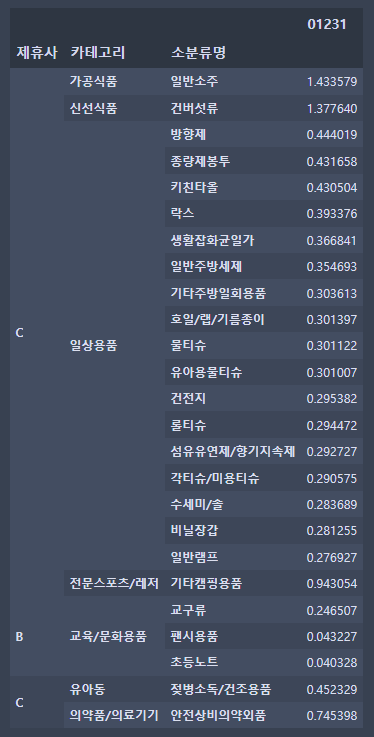

In [190]:
from IPython.display import Image
Image("3개월 기반 추천.png")

# 중분류를 기반으로 재분류를 시행중

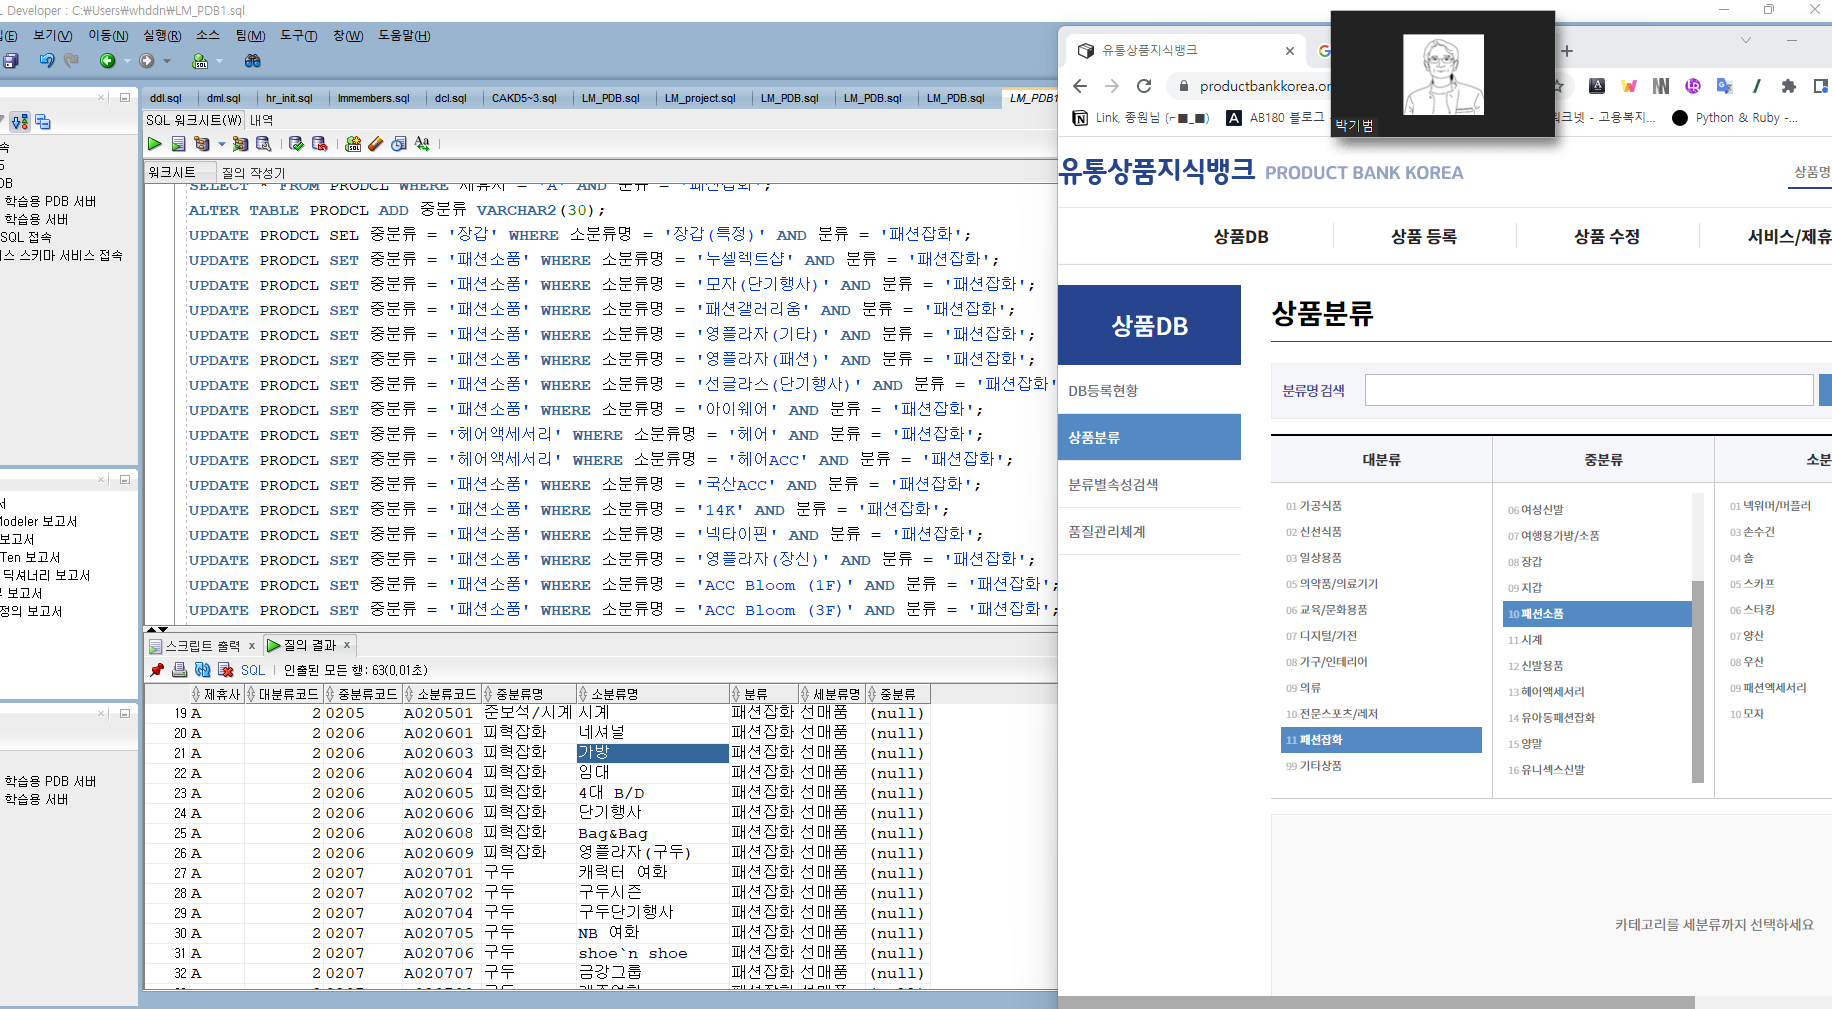

In [189]:
Image("재분류과정.png")